# Import Dependecies 

In [4]:
# Libraries used in every notebook

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import sklearn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

2024-07-24 13:19:51.794356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 13:19:51.794507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 13:19:52.069931: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Hardware

In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
cpus = tf.config.experimental.list_physical_devices("CPU")
for cpu in cpus:
    print(cpu)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Getting the Data

In [8]:
current_path = os.getcwd()
current_path

'/kaggle/working'

In [9]:
'''
train_prompts_path = os.path.join(current_path, "llm-detect-ai-generated-text/", "train_prompts.csv")
train_essays_path = os.path.join(current_path, "llm-detect-ai-generated-text/", "train_essays.csv")
test_essays_path = os.path.join(current_path, "llm-detect-ai-generated-text/", "test_essays.csv")
'''
train_prompts_path = '/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv'
train_essays_path = '/kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
test_essays_path = '/kaggle/input/llm-detect-ai-generated-text/test_essays.csv'

In [10]:
train_prompts_df = pd.read_csv(train_prompts_path)
train_prompts_df.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [11]:
train_essays_df = pd.read_csv(train_essays_path)
train_essays_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [12]:
test_essays_df = pd.read_csv(test_essays_path)
test_essays_df.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


# Analysing the Training Data

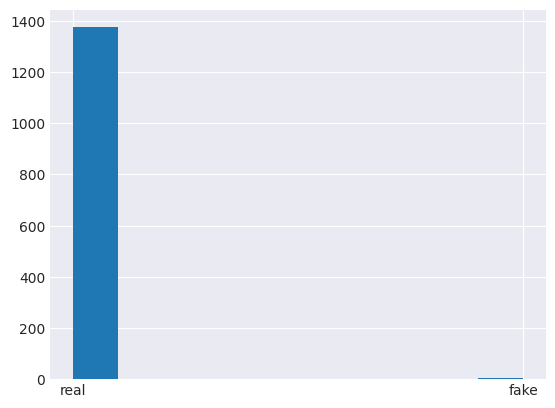

In [13]:
# How many real texts and generated texts are present in the training data?

train_essays_df['label'] = train_essays_df['generated'].apply(lambda x: 'real' if x == 0 else 'fake')

plt.hist(train_essays_df['label'])
plt.show()

This dataset is complete garbage! We need to import some more data generated by AI, for accuracte training of the model.

# Importing More Data 

In [14]:
import glob 

more_data_file_paths = glob.glob('/kaggle/input/daigt-proper-train-dataset/train_drcat_*.csv')

print("File paths found:", more_data_file_paths)

# Check if it worked
if not more_data_file_paths:
    print("No files found matching the pattern.")
else:
    more_dataframes = [pd.read_csv(file) for file in more_data_file_paths]

more_data_combined_df = pd.concat(more_dataframes, ignore_index=True)

more_data_combined_df.head()

File paths found: ['/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv', '/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv', '/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv', '/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv']


,essay_id,text,label,source,prompt,fold
0,6BB4BEB51A80,People can learn without making mistakes. Peop...,0,original_moth,Task: \n\nWrite an essay examining the ways in...,1
1,30A8FB981469,PHONES AND DRIVING\n\nIn this world in which w...,0,persuade_corpus,NaN,2
2,B403A4E28BCE,"Okay, here's my essay:\n\nMaking Your Own Deci...",1,llama2_chat,Task: Write an essay exploring why teenagers s...,8
3,B8F0ECC9DC86,Dear : Principal\n\nI believe that allowing s...,1,mistral7binstruct_v2,\nTask: Should students be encouraged to parti...,8
4,159424F57C24,Well for one if you seek more then one person ...,0,persuade_corpus,NaN,8


In [15]:
more_data_combined_df.shape

(159456, 6)

# Cleaning and Merging Data

For now we will simply use the texts and corresponding labels.

In [16]:
more_data_combined_df.drop(["essay_id", "source", "prompt", "fold"], axis=1, inplace=True)

more_data_combined_df.rename(columns={
    'label': 'generated'
}, inplace=True)

more_data_combined_df['label'] = more_data_combined_df['generated'].apply(lambda x: 'real' if x == 0 else 'fake')

more_data_combined_df.head()

,text,generated,label
0,People can learn without making mistakes. Peop...,0,real
1,PHONES AND DRIVING\n\nIn this world in which w...,0,real
2,"Okay, here's my essay:\n\nMaking Your Own Deci...",1,fake
3,Dear : Principal\n\nI believe that allowing s...,1,fake
4,Well for one if you seek more then one person ...,0,real


In [17]:
train_essays_df.drop(["id", "prompt_id"], axis=1, inplace=True)
train_essays_df.head()

,text,generated,label
0,Cars. Cars have been around since they became ...,0,real
1,Transportation is a large necessity in most co...,0,real
2,"""America's love affair with it's vehicles seem...",0,real
3,How often do you ride in a car? Do you drive a...,0,real
4,Cars are a wonderful thing. They are perhaps o...,0,real


In [18]:
# Finally, we combine the two datasets

train_df = pd.concat([train_essays_df, more_data_combined_df], ignore_index=True)

train_df.head()

,text,generated,label
0,Cars. Cars have been around since they became ...,0,real
1,Transportation is a large necessity in most co...,0,real
2,"""America's love affair with it's vehicles seem...",0,real
3,How often do you ride in a car? Do you drive a...,0,real
4,Cars are a wonderful thing. They are perhaps o...,0,real


In [19]:
train_df.shape

(160834, 3)

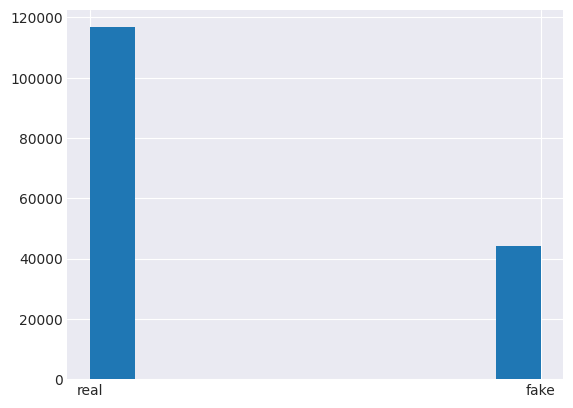

In [20]:
plt.hist(train_df['label'])
plt.show()

This is better, but we will try to make the AI generated (fake) texts hold more weight for our model, to try balance it out.

# Word Clouds

In [21]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [22]:
from wordcloud import WordCloud

def top_words(text, wc):
    word = pd.DataFrame(wc.process_text(''.join(text)).items()).sort_values(1, ascending=False)
    
    print('Top 5 words that appear most frequently:\n')
    for i in range(5):
        item = word.iloc[i]
        print(item[0] + '\t--> ' + str(item[1]))

# Define a function to generate and display the word cloud
def wordmap(adjective):
    dataframe = train_df[train_df["label"] == adjective]["text"]
    
    wc = WordCloud(max_words=1000, min_font_size=10, height=600, width=1200, collocations=False,
                   background_color='#e6ffed', colormap='summer')
    wordcloud = wc.generate(' '.join(dataframe))
    
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(wordcloud)
    
    top_words(dataframe, wc)

Let's see the most commonly used words in AI generated text and compare this to real text.

Top 5 words that appear most frequently:

student	--> 135161
school	--> 71587
help	--> 62317
people	--> 55962
time	--> 54128


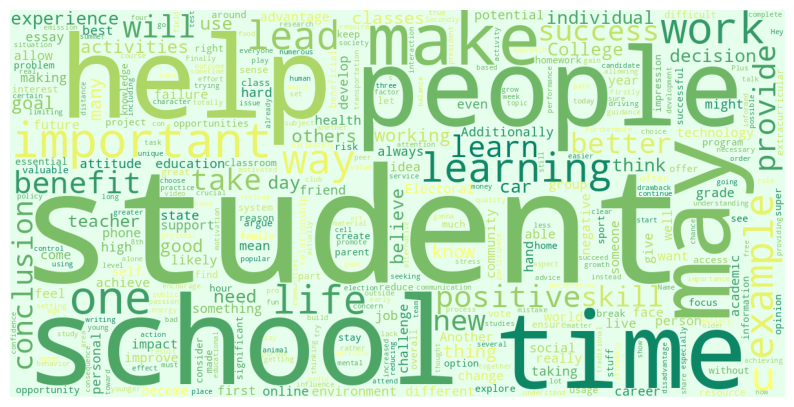

In [23]:
# Generated text

wordmap("fake")

Top 5 words that appear most frequently:

student	--> 541253
people	--> 330173
car	--> 294986
school	--> 293715
will	--> 261227


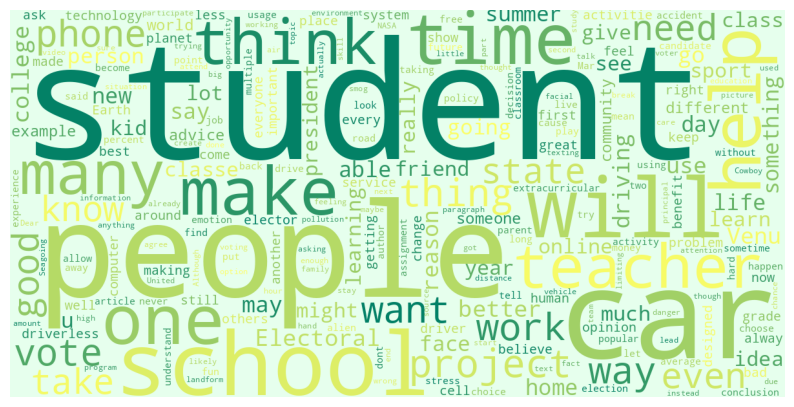

In [24]:
# Real text

wordmap("real")

There were some similarities! Let's now go on forward to create the model.

# Some Installations

In [25]:
pip install keras-nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [26]:
pip install tensorflow transformers

Note: you may need to restart the kernel to use updated packages.


In [27]:
pip install tensorflow transformers sentencepiece

Note: you may need to restart the kernel to use updated packages.


In [28]:
pip uninstall tensorflow keras -y

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Successfully uninstalled keras-2.15.0
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.2 MB/s eta 0:00:0000:0100:05m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sourc

# Creating the Model

In [30]:
import tensorflow.keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Already 0 or 1 so no need for a binarizer
from sklearn.preprocessing import LabelBinarizer 

In [31]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Since our data is imbalanced

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedShuffleSplit

X = train_df["text"]
y = train_df["generated"]

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

X_train_resampled = pd.Series(X_train_resampled.flatten())
y_train_resampled = pd.Series(y_train_resampled)


print("Resampled training set class distribution:\n", y_train_resampled.value_counts())
print("Test set class distribution:\n", y_test.value_counts())

Resampled training set class distribution:
 generated
1    93397
0    93397
Name: count, dtype: int64
Test set class distribution:
 generated
0    23350
1     8817
Name: count, dtype: int64


In [33]:
# Was going to go another route with Roberta - but PyTorch causes issues on my hardware

tokenizer = Tokenizer(num_words=50000, oov_token="<OOV>")

tokenizer.fit_on_texts(X_train_resampled)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train_resampled)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

Total distinct words: 95521


In [34]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Dropout, Dense, LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

def build_model_gen_ai_llm():
    model = Sequential([
        Embedding(total_word+1, 32),
        Bidirectional(LSTM(32, activation="tanh")),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    return model

In [35]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    model_gen_ai_llm = build_model_gen_ai_llm()

    METRICS = [
        tf.keras.metrics.AUC(name="auc")
    ]
    
    model_gen_ai_llm.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss=tensorflow.keras.losses.BinaryCrossentropy(),
        metrics=METRICS
    )

In [36]:
model_gen_ai_llm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Plot model

# keras.utils.plot_model(model_gen_ai_llm, show_shapes=True)

In [38]:
logdir = "Logs"

tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

checkpoint_cb = ModelCheckpoint("gen_ai_llm.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=4, restore_best_weights=True)

train_labels = y_train_resampled
test_labels = y_test

train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_labels = np.array(y_train_resampled)
test_labels = np.array(y_test)

hist = model_gen_ai_llm.fit(train_padded, train_labels, epochs=4, # low epochs because fitting time takes too long
                      validation_data=(test_padded, test_labels),
                      batch_size = 32, 
                      callbacks=[tensorboard_callback, checkpoint_cb, early_stopping_cb])

Epoch 1/4
5838/5838 ━━━━━━━━━━━━━━━━━━━━ 1352s 230ms/step - auc: 0.9814 - loss: 0.1176 - val_auc: 0.9981 - val_loss: 0.0459
Epoch 2/4
5838/5838 ━━━━━━━━━━━━━━━━━━━━ 1347s 231ms/step - auc: 0.9982 - loss: 0.0309 - val_auc: 0.9989 - val_loss: 0.0112
Epoch 3/4
5838/5838 ━━━━━━━━━━━━━━━━━━━━ 1336s 229ms/step - auc: 0.9991 - loss: 0.0201 - val_auc: 0.9993 - val_loss: 0.0101
Epoch 4/4
5838/5838 ━━━━━━━━━━━━━━━━━━━━ 1333s 228ms/step - auc: 0.9995 - loss: 0.0100 - val_auc: 0.9992 - val_loss: 0.0094


In [39]:
def plot(metric=str):
    plt.figure(figsize=(8,6))
    
    plt.plot(hist.history[metric], color="teal", label=metric)
    plt.plot(hist.history["val_" + metric], color="orange", label="val " + metric)
    plt.title(metric)
    plt.legend(loc="upper left")
    
    plt.show()

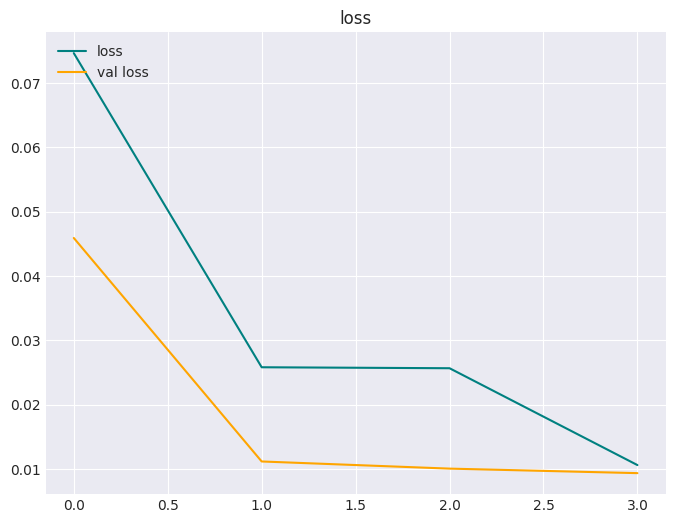

In [40]:
plot("loss")

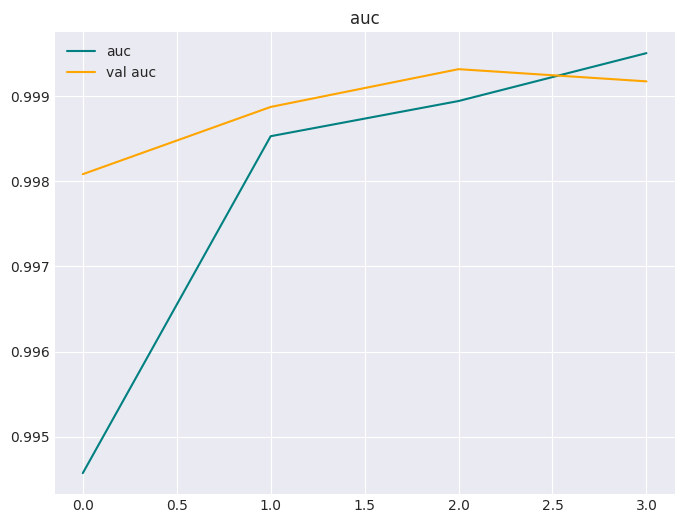

In [41]:
plot("auc")

As already stated, our graphs are 'jumpy' because we did not have many epochs.

# Testing our Model

Let's import some new data and see how our model performs.

In [42]:
argugpt_train = '/kaggle/input/argugpt/machine-train.csv'
argugpt_df = pd.read_csv(argugpt_train)

argugpt_df.head()

,id,prompt_id,prompt,text,model,temperature,exam_type,score,score_level
0,weccl_30,WECCL-17,Some people think the university education is ...,There are many people who think that universit...,text-babbage-001,0.50,weccl,19,high
1,weccl_51,WECCL-17,Some people think the university education is ...,There are a number of reasons why people might...,text-babbage-001,0.65,weccl,13,medium
2,weccl_48,WECCL-17,Some people think the university education is ...,There are many reasons why university educatio...,text-babbage-001,0.65,weccl,13,medium
3,weccl_50,WECCL-17,Some people think the university education is ...,There are many people who think that universit...,text-babbage-001,0.65,weccl,12,low
4,weccl_55,WECCL-17,Some people think the university education is ...,There is a general consensus that university e...,text-babbage-001,0.80,weccl,13,medium


In [47]:
def prediction(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq)
    
    pred = model_gen_ai_llm.predict(padded)
    
    return pred

In [50]:
def get_texts(df, num_texts):
    return df['text'].sample(n=num_texts).reset_index(drop=True)


print("Final Predictions:")
for text in get_texts(argugpt_df, 3):
    pred = prediction(text)
    if pred >= 0.9:
        print(f'Prediction was correct with score {pred}✅') # Since all data from this dataset is AI generated

Final Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction was correct with score [[0.999997]]✅
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction was correct with score [[1.]]✅
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction was correct with score [[0.99999964]]✅
